### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # hides TF info/warning logs
warnings.filterwarnings('ignore')  # hides Python-level warnings
%matplotlib inline


In [2]:
IMG_SIZE = 128  # or 224, depending on your model requirements


### Create Dataset Frame

In [3]:
DATASET_DIR = "plastic_images"  # change if needed


def create_dataframe(root_dir):
    image_paths, labels = [], []
    for label in os.listdir(root_dir):
        subdir = os.path.join(root_dir, label)
        if not os.path.isdir(subdir):
            continue
        for category in ['default', 'real_world']:
            category_path = os.path.join(subdir, category)
            if os.path.exists(category_path):
                for img_name in os.listdir(category_path):
                    image_paths.append(os.path.join(category_path, img_name))
                    labels.append(label)
        print(f"{label} completed.")
    return pd.DataFrame({'image': image_paths, 'label': labels})

df = create_dataframe(DATASET_DIR)
print("Total Images:", len(df))
df.head()


disposable_plastic_cutlery completed.
plastic_cup_lids completed.
plastic_detergent_bottles completed.
plastic_food_containers completed.
plastic_polyethene_bag completed.
plastic_shopping_bags completed.
plastic_soda_bottles completed.
plastic_straws completed.
plastic_trash_bags completed.
plastic_water_bottle completed.
Total Images: 5792


,image,label
0,plastic_images\disposable_plastic_cutlery\defa...,disposable_plastic_cutlery
1,plastic_images\disposable_plastic_cutlery\defa...,disposable_plastic_cutlery
2,plastic_images\disposable_plastic_cutlery\defa...,disposable_plastic_cutlery
3,plastic_images\disposable_plastic_cutlery\defa...,disposable_plastic_cutlery
4,plastic_images\disposable_plastic_cutlery\defa...,disposable_plastic_cutlery


### Split Dataset

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print("Train:", len(train_df), " | Test:", len(test_df))

Train: 4633  | Test: 1159


In [5]:
train_df.head(10)

,image,label
713,plastic_images\plastic_cup_lids\default\Image_...,plastic_cup_lids
4233,plastic_images\plastic_straws\real_world\Image...,plastic_straws
1487,plastic_images\plastic_detergent_bottles\real_...,plastic_detergent_bottles
3893,plastic_images\plastic_straws\default\Image_16...,plastic_straws
1193,plastic_images\plastic_detergent_bottles\defau...,plastic_detergent_bottles
3932,plastic_images\plastic_straws\default\Image_20...,plastic_straws
2195,plastic_images\plastic_polyethene_bag\default\...,plastic_polyethene_bag
4458,plastic_images\plastic_trash_bags\default\Imag...,plastic_trash_bags
2274,plastic_images\plastic_polyethene_bag\default\...,plastic_polyethene_bag
4899,plastic_images\plastic_water_bottle\default\61...,plastic_water_bottle


### Image Preprocessing

In [6]:
def extract_features(image_list, labels_list=None):
    features = []
    valid_indices = []
    
    for idx, image_path in enumerate(tqdm(image_list)):
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
                img = img_to_array(img)
                features.append(img)
                valid_indices.append(idx)
        except Exception as e:
            print(f"\nSkipping problematic file: {image_path} - Error: {str(e)}")
            continue
    
    features = np.array(features)
    
    if labels_list is not None:
        labels = np.array(labels_list)[valid_indices]
        return features, labels
    
    return features

# Process training data
x_train, y_train = extract_features(train_df['image'], train_df['label'].values)
x_test, y_test = extract_features(test_df['image'], test_df['label'].values)

# Normalize
x_train = x_train / 255.0
x_test = x_test / 255.0

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

num_classes = len(le.classes_)

print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")
print("Classes:", le.classes_)

 38%|███▊      | 1748/4633 [00:29<01:05, 44.04it/s]


Skipping problematic file: plastic_images\plastic_water_bottle\default\archive (1).zip - Error: cannot identify image file <_io.BytesIO object at 0x000001C3E7A99F30>


 66%|██████▌   | 3044/4633 [00:51<00:26, 59.38it/s]


Skipping problematic file: plastic_images\plastic_water_bottle\real_world\archive (1).zip - Error: cannot identify image file <_io.BytesIO object at 0x000001C3E7A04B30>


100%|██████████| 1159/1159 [00:18<00:00, 63.30it/s]


Training samples: 4631
Test samples: 1159
Classes: ['disposable_plastic_cutlery' 'plastic_cup_lids'
 'plastic_detergent_bottles' 'plastic_food_containers'
 'plastic_polyethene_bag' 'plastic_shopping_bags' 'plastic_soda_bottles'
 'plastic_straws' 'plastic_trash_bags' 'plastic_water_bottle']


### CNN Model

In [7]:
model = Sequential()

# Pyramid CNN
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)     

### Model Training

In [8]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20


145/145 [==============================] - 29s 187ms/step - loss: 2.0000 - accuracy: 0.3202 - val_loss: 1.7467 - val_accuracy: 0.4081
Epoch 2/20
145/145 [==============================] - 25s 172ms/step - loss: 1.5917 - accuracy: 0.4675 - val_loss: 1.4236 - val_accuracy: 0.5522
Epoch 3/20
145/145 [==============================] - 23s 157ms/step - loss: 1.2510 - accuracy: 0.5757 - val_loss: 1.1962 - val_accuracy: 0.6385
Epoch 4/20
145/145 [==============================] - 23s 159ms/step - loss: 0.9699 - accuracy: 0.6893 - val_loss: 1.0746 - val_accuracy: 0.7006
Epoch 5/20
145/145 [==============================] - 26s 180ms/step - loss: 0.7618 - accuracy: 0.7607 - val_loss: 0.9052 - val_accuracy: 0.7455
Epoch 6/20
145/145 [==============================] - 23s 160ms/step - loss: 0.5773 - accuracy: 0.8186 - val_loss: 0.8171 - val_accuracy: 0.7645
Epoch 7/20
145/145 [==============================] - 26s 178ms/step - loss: 0.4438 - accuracy: 0.8612 - val_loss: 0.8025 - val_

KeyboardInterrupt: 

### Save Model

In [9]:
# Save model structure + weights
model_json = model.to_json()
with open("plastic_cnn.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("plastic_cnn.h5")

print("✅ Model saved as plastic_cnn.json and plastic_cnn.h5")

✅ Model saved as plastic_cnn.json and plastic_cnn.h5


### Load & Test Model

✅ Model loaded
1/1 [==============================] - 0s 165ms/step
Prediction: plastic_food_containers (99.75%)


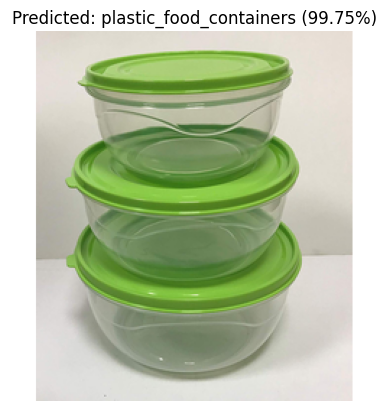

In [10]:
# Load model
with open('plastic_cnn.json', 'r') as json_file:
    model_json = json_file.read()

model = model_from_json(model_json)
model.load_weights('plastic_cnn.h5')
print("✅ Model loaded")

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array

def predict_image(image_path):
    img_array = preprocess_image(image_path)
    pred = model.predict(img_array)
    label_idx = pred.argmax()
    class_label = le.classes_[label_idx]
    confidence = pred[0][label_idx] * 100
    print(f"Prediction: {class_label} ({confidence:.2f}%)")

    plt.imshow(load_img(image_path))
    plt.title(f"Predicted: {class_label} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

# Example test
test_img =r"C:\Users\pranj\OneDrive\Desktop\CNN_Implementation\plastic_images\plastic_food_containers\default\Image_5.png"  # change path
predict_image(test_img)


1/1 [==============================] - 0s 37ms/step
Prediction: plastic_trash_bags (99.77%)


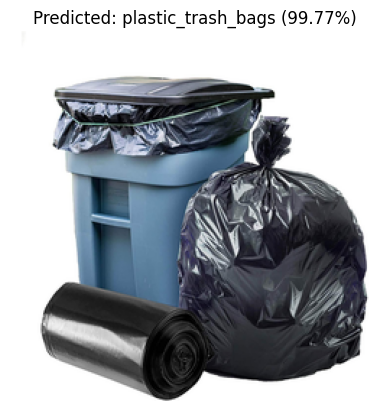

In [11]:
test_img =r"C:\Users\pranj\OneDrive\Desktop\CNN_Implementation\plastic_images\plastic_trash_bags\default\Image_1.png"  # change path
predict_image(test_img)


1/1 [==============================] - 0s 41ms/step
Prediction: plastic_trash_bags (99.95%)


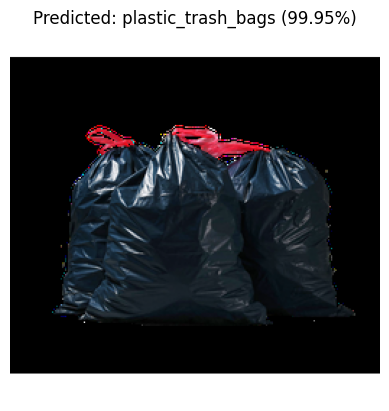

In [15]:
test_img = r"C:\Users\pranj\OneDrive\Desktop\CNN_Implementation\plastic_images\plastic_trash_bags\default\Image_245.png"
predict_image(test_img)

1/1 [==============================] - 0s 37ms/step
Prediction: plastic_trash_bags (100.00%)


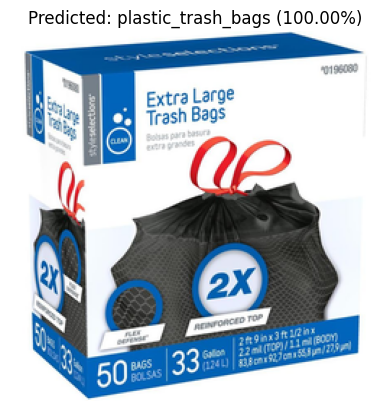

In [16]:
test_img = r"plastic_images/plastic_trash_bags/real_world/Image_248.png"
predict_image(test_img)

1/1 [==============================] - 0s 44ms/step
Prediction: plastic_water_bottle (100.00%)


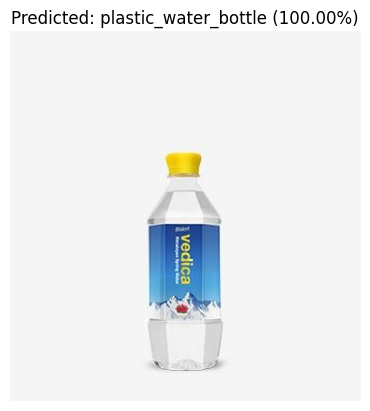

In [17]:
test_img = r"C:\Users\pranj\OneDrive\Desktop\CNN_Implementation\plastic_images\plastic_water_bottle\default\0bnC0a9OdzJtymklrmne_1_11zon.jpeg"
predict_image(test_img)